<a href="https://colab.research.google.com/github/gimenopea/EMSE6574/blob/master/EMSE6574_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Background
### Predicting Coronavirus Cases and Death Rates within the District of Columbia with district census features

data source:

https://coronavirus.dc.gov/data

3 datasets to join together:
1. Total Cases per Ward
2. Total Lives Lost per Ward
3. Demographics per each Ward


Goal: 

1. Implement regression models and ARIMA based models to predict cases/Deaths in Washington, DC in the months of December 2020 and Jan 2021


# Data Prep/Clean Up

In [193]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [194]:
df_cases = pd.read_csv('/content/drive/MyDrive/EMSE 6574 Final Project Files/cases_by_ward.csv')
df_cases.head()

,Ward,31-Mar,1-Apr,2-Apr,3-Apr,4-Apr,5-Apr,6-Apr,7-Apr,8-Apr,9-Apr,10-Apr,11-Apr,12-Apr,13-Apr,14-Apr,15-Apr,16-Apr,17-Apr,18-Apr,19-Apr,20-Apr,21-Apr,22-Apr,23-Apr,24-Apr,25-Apr,26-Apr,27-Apr,28-Apr,29-Apr,30-Apr,1-May,2-May,3-May,4-May,5-May,6-May,7-May,8-May,...,11-Oct,12-Oct,13-Oct,14-Oct,15-Oct,16-Oct,17-Oct,18-Oct,19-Oct,20-Oct,21-Oct,22-Oct,23-Oct,24-Oct,25-Oct,26-Oct,27-Oct,28-Oct,29-Oct,30-Oct,31-Oct,1-Nov,2-Nov,3-Nov,4-Nov,5-Nov,6-Nov,7-Nov,8-Nov,9-Nov,10-Nov,11-Nov,12-Nov,13-Nov,14-Nov,15-Nov,16-Nov,17-Nov,18-Nov,19-Nov
0,1,65,75,84,100,107,119,135,160,172,183,202,218,223,230,243,264,282,309,330,344,355,359,376,403,427,444,450,475,503,543,593,621,649,668,694,710,746,774,809,...,2073,2076,2085,2088,2104,2131,2131,2138,2142,2144,2156,2164,2176,2187,2193,2208,2220,2242,2259,2274,2295,2304,2318,2329,2334,2364,2365,2383,2393,2400,2413,2426,2442,2459,2480,2488,2518,2539,2560,2575
1,2,60,73,79,92,92,107,117,134,137,145,151,160,180,182,183,193,207,215,218,225,228,234,252,251,256,261,261,266,284,291,317,318,325,333,345,352,357,372,377,...,1068,1068,1069,1070,1073,1077,1082,1082,1089,1090,1097,1102,1107,1117,1119,1132,1140,1146,1153,1165,1173,1181,1189,1204,1214,1231,1248,1267,1273,1285,1301,1317,1338,1362,1381,1390,1416,1433,1455,1470
2,3,70,73,77,79,83,89,95,104,113,128,139,143,146,149,161,169,176,205,211,226,223,215,227,252,258,268,261,264,270,282,294,302,311,314,317,326,332,339,343,...,791,791,797,799,808,810,810,812,816,822,823,826,832,837,838,844,848,850,855,862,865,867,878,883,885,893,901,912,920,929,952,957,969,975,983,986,1001,1010,1025,1026
3,4,85,96,108,135,145,168,185,223,244,267,288,303,312,326,361,389,423,459,477,499,515,543,562,595,636,663,681,702,727,774,849,889,931,980,1009,1044,1089,1150,1203,...,3008,3020,3032,3038,3044,3054,3065,3073,3081,3089,3091,3108,3119,3129,3139,3150,3159,3173,3182,3197,3212,3233,3244,3254,3271,3284,3303,3314,3331,3344,3378,3391,3414,3433,3463,3473,3505,3524,3555,3570
4,5,76,83,98,122,126,136,150,179,198,210,231,250,257,262,278,311,328,350,363,383,404,429,456,488,513,552,571,587,622,646,699,722,768,799,819,846,887,930,971,...,2570,2577,2582,2590,2612,2622,2631,2634,2644,2649,2656,2669,2684,2691,2694,2706,2716,2729,2734,2743,2761,2769,2777,2783,2796,2809,2825,2836,2848,2853,2883,2907,2921,2947,2968,2984,3029,3055,3081,3102


In [195]:
df_cases.set_index('Ward',inplace=True)

In [196]:
#reformat the dates so they can be used as an index

df_cases.columns = pd.to_datetime(df_cases.columns, format="%d-%b")
df_cases.columns = [pd.datetime(2020,x.month,x.day) for x in df_cases.columns.tolist()]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  after removing the cwd from sys.path.


In [197]:
#transpose the df 
d_cases = df_cases.T

In [198]:
d_cases.columns = [f'Ward {x}' for x in d_cases.columns.tolist()]

In [199]:
d_cases.head(3)

,Ward 1,Ward 2,Ward 3,Ward 4,Ward 5,Ward 6,Ward 7,Ward 8
2020-03-31,65,60,70,85,76,101,60,44
2020-04-01,75,73,73,96,83,112,66,51
2020-04-02,84,79,77,108,98,130,83,58


In [200]:
# the data is a running cumulative sum, must undo it so it just displays the number of cases for that particular day

#adding extra row as a 0 starting point
d_cases.loc[pd.datetime(2020,3,30)] = 0
d_cases.sort_index(inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  after removing the cwd from sys.path.


In [201]:
#shift difference 1 row down
d_cases_shifted = d_cases - d_cases.shift()
d_cases_shifted.head(3)

,Ward 1,Ward 2,Ward 3,Ward 4,Ward 5,Ward 6,Ward 7,Ward 8
2020-03-30,nan,nan,nan,nan,nan,nan,nan,nan
2020-03-31,65.00,60.00,70.00,85.00,76.00,101.00,60.00,44.00
2020-04-01,10.00,13.00,3.00,11.00,7.00,11.00,6.00,7.00


In [202]:
d_cases_shifted = d_cases_shifted.dropna().astype(int)
d_cases_shifted.head(3)

,Ward 1,Ward 2,Ward 3,Ward 4,Ward 5,Ward 6,Ward 7,Ward 8
2020-03-31,65,60,70,85,76,101,60,44
2020-04-01,10,13,3,11,7,11,6,7
2020-04-02,9,6,4,12,15,18,17,7


In [203]:
#stack the dataframe so the columns are condensed to 1 feature column
df_stacked = d_cases_shifted.stack().to_frame().reset_index().rename({'level_0': 'date','level_1': 'Ward',0:'Total Cases'}, axis=1)

#! use this dataframe to join with the other ones below df_stacked.
df_stacked.set_index('date',inplace=True)
df_stacked.head()

,Ward,Total Cases
date,,
2020-03-31,Ward 1,65
2020-03-31,Ward 2,60
2020-03-31,Ward 3,70
2020-03-31,Ward 4,85
2020-03-31,Ward 5,76


In [204]:
# adding total deaths by ward

deaths_df = pd.read_csv('/content/drive/MyDrive/EMSE 6574 Final Project Files/lives_lost_by_ward.csv')
deaths_df.drop(0,axis=0,inplace=True)
deaths_df.set_index('Ward',inplace=True)
deaths_df.head(3)

,19-Apr,20-Apr,21-Apr,22-Apr,23-Apr,24-Apr,25-Apr,26-Apr,27-Apr,28-Apr,29-Apr,30-Apr,1-May,2-May,3-May,4-May,5-May,6-May,7-May,8-May,9-May,10-May,11-May,12-May,13-May,14-May,15-May,16-May,17-May,18-May,19-May,20-May,21-May,22-May,23-May,24-May,25-May,26-May,27-May,28-May,...,11-Oct,12-Oct,13-Oct,14-Oct,15-Oct,16-Oct,17-Oct,18-Oct,19-Oct,20-Oct,21-Oct,22-Oct,23-Oct,24-Oct,25-Oct,26-Oct,27-Oct,28-Oct,29-Oct,30-Oct,31-Oct,1-Nov,2-Nov,3-Nov,4-Nov,5-Nov,6-Nov,7-Nov,8-Nov,9-Nov,10-Nov,11-Nov,12-Nov,13-Nov,14-Nov,15-Nov,16-Nov,17-Nov,18-Nov,19-Nov
Ward,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,6,6,6,8,8,11,11,11,12,17,21,21,21,21,21,22,24,25,25,28,32,29,31,32,33,33,35,35,36,36,36,37,37,40,41,43,43,45,46,47,...,70,70,71,71,71,71,71,71,71,71,71,71,71,71,71,71,71,71,71,71,71,71,71,71,72,73,74,74,75,76,76,76,76,76,76,76,76,77,77,77
2,1,1,1,3,4,5,6,7,8,9,10,13,14,14,14,14,15,15,16,17,18,16,17,18,18,20,22,23,24,25,25,25,26,26,26,27,27,27,27,29,...,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37
3,9,9,10,10,12,12,12,13,14,14,14,14,15,15,15,15,18,18,19,19,21,21,22,23,23,24,24,25,25,25,26,27,27,28,29,30,30,30,30,30,...,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34


In [205]:
#reformat the dates so they can be used as an index

deaths_df.columns = pd.to_datetime(deaths_df.columns, format="%d-%b")
deaths_df.columns = [pd.datetime(2020,x.month,x.day) for x in deaths_df.columns.tolist()]
deaths_df.head(3)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  after removing the cwd from sys.path.


,2020-04-19,2020-04-20,2020-04-21,2020-04-22,2020-04-23,2020-04-24,2020-04-25,2020-04-26,2020-04-27,2020-04-28,2020-04-29,2020-04-30,2020-05-01,2020-05-02,2020-05-03,2020-05-04,2020-05-05,2020-05-06,2020-05-07,2020-05-08,2020-05-09,2020-05-10,2020-05-11,2020-05-12,2020-05-13,2020-05-14,2020-05-15,2020-05-16,2020-05-17,2020-05-18,2020-05-19,2020-05-20,2020-05-21,2020-05-22,2020-05-23,2020-05-24,2020-05-25,2020-05-26,2020-05-27,2020-05-28,...,2020-10-11,2020-10-12,2020-10-13,2020-10-14,2020-10-15,2020-10-16,2020-10-17,2020-10-18,2020-10-19,2020-10-20,2020-10-21,2020-10-22,2020-10-23,2020-10-24,2020-10-25,2020-10-26,2020-10-27,2020-10-28,2020-10-29,2020-10-30,2020-10-31,2020-11-01,2020-11-02,2020-11-03,2020-11-04,2020-11-05,2020-11-06,2020-11-07,2020-11-08,2020-11-09,2020-11-10,2020-11-11,2020-11-12,2020-11-13,2020-11-14,2020-11-15,2020-11-16,2020-11-17,2020-11-18,2020-11-19
Ward,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,6,6,6,8,8,11,11,11,12,17,21,21,21,21,21,22,24,25,25,28,32,29,31,32,33,33,35,35,36,36,36,37,37,40,41,43,43,45,46,47,...,70,70,71,71,71,71,71,71,71,71,71,71,71,71,71,71,71,71,71,71,71,71,71,71,72,73,74,74,75,76,76,76,76,76,76,76,76,77,77,77
2,1,1,1,3,4,5,6,7,8,9,10,13,14,14,14,14,15,15,16,17,18,16,17,18,18,20,22,23,24,25,25,25,26,26,26,27,27,27,27,29,...,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37
3,9,9,10,10,12,12,12,13,14,14,14,14,15,15,15,15,18,18,19,19,21,21,22,23,23,24,24,25,25,25,26,27,27,28,29,30,30,30,30,30,...,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34


In [206]:
#transpose and rename columns
deaths_df.index = [f'Ward {x}' for x in deaths_df.index.tolist()]
deaths_df = deaths_df.T
deaths_df.head(3)

,Ward 1,Ward 2,Ward 3,Ward 4,Ward 5,Ward 6,Ward 7,Ward 8
2020-04-19,6,1,9,14,12,18,16,22
2020-04-20,6,1,9,15,13,21,16,24
2020-04-21,6,1,10,16,17,23,17,29


In [207]:
# the data is a running cumulative sum, must undo it so it just displays the number of cases for that particular day

#adding extra row as a 0 starting point
deaths_df.loc[pd.datetime(2020,3,30)] = 0
deaths_df.sort_index(inplace=True)
deaths_df.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  after removing the cwd from sys.path.


,Ward 1,Ward 2,Ward 3,Ward 4,Ward 5,Ward 6,Ward 7,Ward 8
2020-03-30,0,0,0,0,0,0,0,0
2020-04-19,6,1,9,14,12,18,16,22
2020-04-20,6,1,9,15,13,21,16,24
2020-04-21,6,1,10,16,17,23,17,29
2020-04-22,8,3,10,17,19,25,18,30


In [208]:
#shift rows, undo cumulative sum, drop first first, convert back to int
deaths_df_shifted = deaths_df - deaths_df.shift()
deaths_df_shifted = deaths_df_shifted.dropna().astype(int)
deaths_df_shifted.head(3)

,Ward 1,Ward 2,Ward 3,Ward 4,Ward 5,Ward 6,Ward 7,Ward 8
2020-04-19,6,1,9,14,12,18,16,22
2020-04-20,0,0,0,1,1,3,0,2
2020-04-21,0,0,1,1,4,2,1,5


In [209]:
#create total deaths column

deaths_df = deaths_df_shifted.stack().to_frame().reset_index().rename({'level_0':'date','level_1':'Ward',0:'total_deaths'},axis=1).set_index('date')

#file 2 final dataframe
deaths_df.head()


,Ward,total_deaths
date,,
2020-04-19,Ward 1,6
2020-04-19,Ward 2,1
2020-04-19,Ward 3,9
2020-04-19,Ward 4,14
2020-04-19,Ward 5,12


In [210]:
df_stacked.reset_index(inplace=True)

In [211]:
df_j = df_stacked.set_index(['date','Ward']);

In [212]:
df_d = deaths_df.reset_index().set_index(['date','Ward'])

In [213]:
#combine the 2 previous dataframes

df_j['total_deaths'] = df_d
df_stacked = df_j.reset_index()
df_stacked.set_index('date',inplace=True)

df_stacked.head()





,Ward,Total Cases,total_deaths
date,,,
2020-03-31,Ward 1,65,nan
2020-03-31,Ward 2,60,nan
2020-03-31,Ward 3,70,nan
2020-03-31,Ward 4,85,nan
2020-03-31,Ward 5,76,nan


In [214]:
#drop dates where there is no recorded deaths
df_stacked = df_stacked[~df_stacked['total_deaths'].isna()]
df_stacked.head()

,Ward,Total Cases,total_deaths
date,,,
2020-04-19,Ward 1,14,6.00
2020-04-19,Ward 2,7,1.00
2020-04-19,Ward 3,15,9.00
2020-04-19,Ward 4,22,14.00
2020-04-19,Ward 5,20,12.00


In [215]:
# file #3 import demographic data per each ward and merge it with the other dataframe

df_demo = pd.read_csv('/content/drive/MyDrive/EMSE 6574 Final Project Files/Ward_from_2012.csv')
df_demo.drop(['LABEL','OBJECTID','WARD','REP_NAME','WEB_URL','REP_PHONE','REP_EMAIL','REP_OFFICE','WARD_ID','SHAPE_LENGTH0','SHAPE_AREA0','SHAPELEN','SHAPEAREA','MED_VAL_OOU','POP_2000','POP_2010',
              'POP_25_PLUS','MARRIED_COUPLE_FAMILY'],axis=1,inplace=True)
df_demo.rename({'NAME':'Ward'},axis=1,inplace=True)
df_demo.head(3)

,Ward,AREASQMI,POP_2011_2015,POP_BLACK,POP_NATIVE_AMERICAN,POP_ASIAN,POP_HAWAIIAN,POP_OTHER_RACE,TWO_OR_MORE_RACES,NOT_HISPANIC_OR_LATINO,HISPANIC_OR_LATINO,POP_MALE,POP_FEMALE,AGE_0_5,AGE_5_9,AGE_10_14,AGE_15_17,AGE_18_19,AGE_20,AGE_21,AGE_22_24,AGE_25_29,AGE_30_34,AGE_35_39,AGE_40_44,AGE_45_49,AGE_50_54,AGE_55_59,AGE_60_61,AGE_65_66,AGE_67_69,AGE_70_74,AGE_75_79,AGE_80_84,AGE_85_PLUS,MEDIAN_AGE,UNEMPLOYMENT_RATE,TOTAL_HH,FAMILY_HH,PCT_FAMILY_HH,NONFAMILY_HH,PCT_NONFAMILY_HH,PCT_BELOW_POV,PCT_BELOW_POV_FAM,PCT_BELOW_POV_WHITE,PCT_BELOW_POV_BLACK,PCT_BELOW_POV_NAT_AMER,PCT_BELOW_POV_ASIAN,PCT_BELOW_POV_HAWAIIAN,PCT_BELOW_POV_OTHER,PCT_BELOW_POV_TWO_RACES,POP_25_PLUS_9TH_GRADE,POP_25_PLUS_GRADUATE,MALE_HH_NO_WIFE,FEMALE_HH_NO_HUSBAND,MEDIAN_HH_INCOME,PER_CAPITA_INCOME,PCT_BELOW_POV_HISP,PCT_BELOW_POV_WHTE_NOHISP,NO_DIPLOMA_25_PLUS,DIPLOMA_25_PLUS,NO_DEGREE_25_PLUS,ASSOC_DEGREE_25_PLUS,BACH_DEGREE_25_PLUS
0,Ward 8,11.94,81133,75259,110,310,12,711,872,79843,1290,35573,45560,7879,7061,5963,3596,2945,1800,1748,4070,6306,5951,4617,4873,4429,4978,5001,1578,1011,1211,1904,1026,634,432,29.30,22.90,29470,17747,60.22,11723,39.78,37.70,35.30,10.80,38.80,54.10,21.60,0,51.20,36.40,1858,2614,1886,11653,30910,17596,36.30,10.80,5958,18736,10975,2149,3781
1,Ward 6,6.22,84290,29909,295,3573,40,1233,2529,79000,5290,40411,43879,4779,2747,2235,1088,1370,794,724,4596,13427,12512,8052,5474,4524,4350,4724,1830,1518,1596,2167,1522,816,958,33.90,6.30,40100,15110,37.68,24990,62.32,12.50,9.60,4.50,25.70,13.90,11.60,0,10.70,6.20,1785,25882,944,4157,94343,58354,6.30,4.50,3128,7079,6643,1852,19588
2,Ward 7,8.81,73290,69005,219,225,17,1211,908,70987,2303,33916,39374,5230,4485,4333,2944,2162,1347,1107,3170,5036,5083,4154,5166,4794,5715,5272,1716,1254,1680,2370,1719,1290,1142,37.00,19.10,29266,15574,53.22,13692,46.78,27.20,23.60,8.90,28.00,12.80,5.30,0,19.70,20.00,2259,3309,1682,9499,39165,22917,22.90,8.90,6002,18683,10800,2569,4890


In [216]:
joined_df = pd.merge(df_stacked.reset_index(),df_demo,how='left',on='Ward')


joined_df['date_index'] = joined_df['date']
joined_df.set_index('date_index',inplace=True)

#this is the final dataframe for analysis master_df
master_df = joined_df

# going to condense the age groups master dataframe


master_df['Age_0_19'] = master_df['AGE_0_5'] + master_df['AGE_5_9'] + master_df['AGE_10_14'] + master_df['AGE_15_17'] + master_df['AGE_18_19']  
master_df['Age_20_29'] = master_df['AGE_20'] + master_df['AGE_21'] + master_df['AGE_22_24'] + master_df['AGE_25_29'] 
master_df['Age_30_39'] = master_df['AGE_30_34'] + master_df['AGE_35_39']
master_df['Age_40_49'] = master_df['AGE_40_44'] + master_df['AGE_45_49']
master_df['Age_50_59'] = master_df['AGE_50_54'] + master_df['AGE_55_59']
master_df['Age_60_plus'] = master_df['AGE_60_61'] + master_df['AGE_65_66'] + master_df['AGE_67_69'] + master_df['AGE_70_74'] + master_df['AGE_75_79'] + master_df['AGE_80_84'] + master_df['AGE_85_PLUS']
master_df['total_cases'] = master_df['Total Cases']

master_df = master_df[['date','Ward','total_cases','total_deaths','AREASQMI','POP_2011_2015','POP_BLACK','POP_NATIVE_AMERICAN','POP_ASIAN','POP_HAWAIIAN','POP_OTHER_RACE','TWO_OR_MORE_RACES','POP_MALE','POP_FEMALE','Age_0_19','Age_20_29','Age_30_39','Age_40_49','Age_50_59','Age_60_plus','MEDIAN_HH_INCOME']]

#master dataframe for all analysis in this book master_df

master_df.head()

,date,Ward,total_cases,total_deaths,AREASQMI,POP_2011_2015,POP_BLACK,POP_NATIVE_AMERICAN,POP_ASIAN,POP_HAWAIIAN,POP_OTHER_RACE,TWO_OR_MORE_RACES,POP_MALE,POP_FEMALE,Age_0_19,Age_20_29,Age_30_39,Age_40_49,Age_50_59,Age_60_plus,MEDIAN_HH_INCOME
date_index,,,,,,,,,,,,,,,,,,,,,
2020-04-19,2020-04-19,Ward 1,14,6.00,2.54,82859,25110,300,3509,111,6259,2596,41368,41491,12933,24342,19664,9883,6581,7405,82159
2020-04-19,2020-04-19,Ward 2,7,1.00,8.68,77645,6817,213,7640,30,2496,2875,39214,38431,10540,25925,16966,7620,6661,8100,100388
2020-04-19,2020-04-19,Ward 3,15,9.00,10.93,83152,5730,163,5188,0,1864,3345,37151,46001,16264,15517,13443,10521,9589,15242,112873
2020-04-19,2020-04-19,Ward 4,22,14.00,9.00,83066,46884,519,1755,31,9627,2287,40349,42717,18079,11268,13062,12166,11786,13969,74600
2020-04-19,2020-04-19,Ward 5,20,12.00,10.39,82049,57733,335,1622,9,3758,1915,38692,43357,17470,15460,13435,10056,10179,13006,57554


# Exploratory Data Analysis on the Preliminary Data Set

In [217]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1720 entries, 2020-04-19 to 2020-11-19
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 1720 non-null   datetime64[ns]
 1   Ward                 1720 non-null   object        
 2   total_cases          1720 non-null   int64         
 3   total_deaths         1720 non-null   float64       
 4   AREASQMI             1720 non-null   float64       
 5   POP_2011_2015        1720 non-null   int64         
 6   POP_BLACK            1720 non-null   int64         
 7   POP_NATIVE_AMERICAN  1720 non-null   int64         
 8   POP_ASIAN            1720 non-null   int64         
 9   POP_HAWAIIAN         1720 non-null   int64         
 10  POP_OTHER_RACE       1720 non-null   int64         
 11  TWO_OR_MORE_RACES    1720 non-null   int64         
 12  POP_MALE             1720 non-null   int64         
 13  POP_FEMALE     

In [218]:
pd.options.display.float_format = "{:.2f}".format
master_df.describe()

,total_cases,total_deaths,AREASQMI,POP_2011_2015,POP_BLACK,POP_NATIVE_AMERICAN,POP_ASIAN,POP_HAWAIIAN,POP_OTHER_RACE,TWO_OR_MORE_RACES,POP_MALE,POP_FEMALE,Age_0_19,Age_20_29,Age_30_39,Age_40_49,Age_50_59,Age_60_plus,MEDIAN_HH_INCOME
count,1720.00,1720.00,1720.00,1720.00,1720.00,1720.00,1720.00,1720.00,1720.00,1720.00,1720.00,1720.00,1720.00,1720.00,1720.00,1720.00,1720.00,1720.00,1720.00
mean,9.70,0.38,8.56,80935.50,39555.88,269.25,2977.75,31.25,3394.88,2165.88,38334.25,42601.25,16762.88,17079.62,14617.38,9938.25,9354.50,10887.00,73999.00
std,9.05,1.19,2.79,3446.37,25116.67,117.64,2379.93,32.57,2894.20,832.71,2425.14,2539.65,4955.28,5328.96,3823.56,1178.40,1758.63,2800.63,27459.99
min,-16.00,-3.00,2.54,73290.00,5730.00,110.00,225.00,0.00,711.00,872.00,33916.00,38431.00,10540.00,10660.00,9237.00,7620.00,6581.00,7405.00,30910.00
25%,4.00,0.00,8.07,80261.00,20536.75,200.50,1294.00,11.25,1227.50,1663.25,36756.50,40961.75,12754.50,13260.00,12438.50,9737.75,8470.75,8024.00,52956.75
50%,7.00,0.00,8.91,82454.00,38396.50,257.00,2632.00,23.50,2180.00,2408.00,38953.00,43037.00,16867.00,15488.50,13439.00,9979.00,9784.00,10789.00,78379.50
75%,12.00,0.00,10.53,83087.50,60551.00,308.75,3976.75,33.25,4383.25,2665.75,40364.50,44299.25,18347.75,20741.25,17640.50,10172.25,10381.00,13246.75,95854.25
max,75.00,22.00,11.94,84290.00,75259.00,519.00,7640.00,111.00,9627.00,3345.00,41368.00,46001.00,27444.00,25925.00,20564.00,12166.00,11786.00,15242.00,112873.00


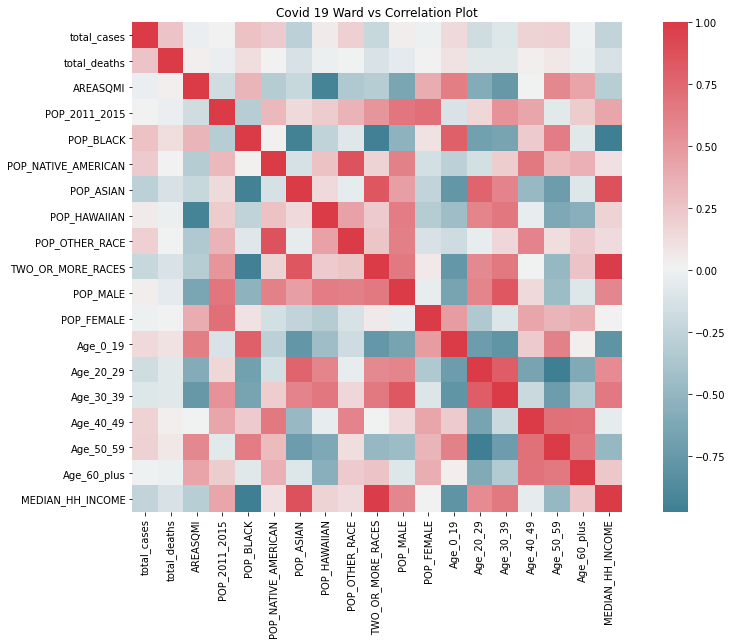

In [219]:
import seaborn as sns
fig,ax = plt.subplots(figsize=(15,9))
corr = master_df.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, 
            cmap=sns.diverging_palette(220,10,as_cmap=True),
            square=True, 
            ax=ax).set_title('Covid 19 Ward vs Correlation Plot');

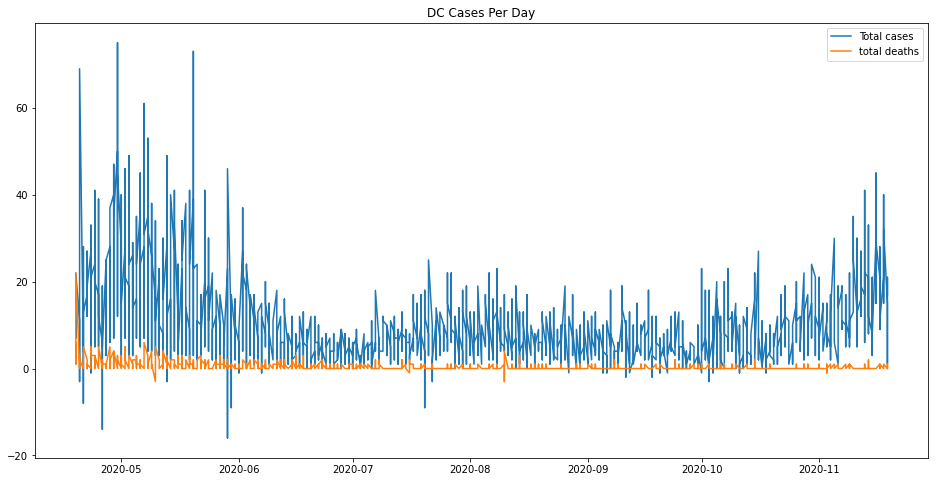

In [220]:
fig,ax = plt.subplots(figsize=(16,8))
ax.set_title('DC Cases Per Day')
plt.plot(master_df.index,master_df['total_cases'],label='Total cases')
plt.plot(master_df.index,master_df['total_deaths'],label='total deaths')
plt.legend();

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


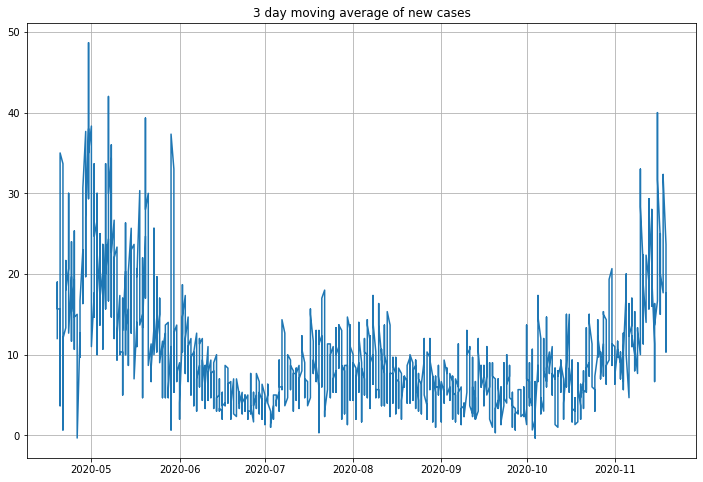

In [221]:
moving_average = 3
master_df['total_cases_moving_average'] = master_df['total_cases'].rolling(window=moving_average).mean()
fig,ax = plt.subplots(figsize=(12,8))
ax.grid()
ax.plot(master_df.index,master_df['total_cases_moving_average'])
ax.set_title('3 day moving average of new cases');



---


#  ---- Modeling using regression --- 


In [483]:
 from sklearn.metrics import mean_squared_error
 from sklearn.linear_model import LinearRegression
 from sklearn.model_selection import train_test_split
 from sklearn.metrics import r2_score

# Model 1: Simple Linear Regression




In [490]:
#understanding total cases per month based on 1 variable

In [502]:
reg_df = master_df.resample(rule='D').sum()[['total_cases']]
reg_df['days_since_start'] = [x for x in range(len(reg_df))]
reg_df

,total_cases,days_since_start
date_index,,
2020-04-19,125,0
2020-04-20,153,1
2020-04-21,91,2
2020-04-22,147,3
2020-04-23,154,4
...,...,...
2020-11-15,87,210
2020-11-16,243,211
2020-11-17,152,212


In [509]:
#splits for linear regression
X = reg_df[['days_since_start']]
y = reg_df[['total_cases']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)


In [510]:
linear_reg = LinearRegression(fit_intercept=True)
linear_reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [511]:
linear_reg.score(X_test,y_test)
#very bad score

0.014763828359964261

In [562]:
#how good is the model in terms of RMSE

linear_reg_rmse = mean_squared_error(y_test,linear_reg.predict(X_test),squared=False)

print(f' RMSE: {linear_reg_rmse}')

 RMSE: 63.84234315168581


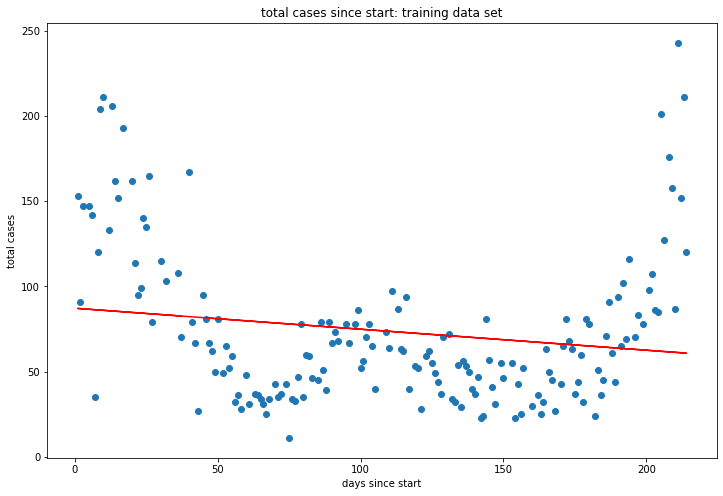

In [517]:
fig,ax = plt.subplots(figsize=(12,8))
plt.scatter(X_train,y_train)
plt.plot(X_train,linear_reg.predict(X_train),color='red')
plt.xlabel('days since start')
plt.ylabel('total cases')
plt.title('total cases since start: training data set');

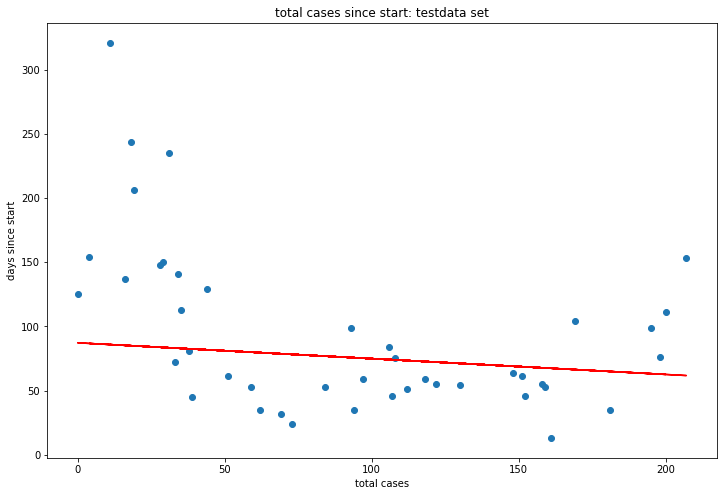

In [516]:
fig,ax = plt.subplots(figsize=(12,8))
plt.scatter(X_test,y_test)
plt.plot(X_test,linear_reg.predict(X_test),color='red')
plt.xlabel('total cases')
plt.ylabel('days since start')
plt.title('total cases since start: testdata set');

In [539]:
#data ends on Nov 19, 2020
#days on prediction ends on day 214


In [528]:
forecast_date_range = np.arange(214,214+30)
forecast_date_range

array([214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226,
       227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239,
       240, 241, 242, 243])

In [534]:
#forecast the next 30 days
forecast_values = []
for n in forecast_date_range:
  prediction = round(linear_reg.predict([[n]])[0][0])
  print(f'on the {n}th day, beginning November 20, 2020 the model predicts: {prediction} cases')
  forecast_values.append(prediction)



on the 214th day, beginning November 20, 2020 the model predicts: 61.0 cases
on the 215th day, beginning November 20, 2020 the model predicts: 61.0 cases
on the 216th day, beginning November 20, 2020 the model predicts: 61.0 cases
on the 217th day, beginning November 20, 2020 the model predicts: 60.0 cases
on the 218th day, beginning November 20, 2020 the model predicts: 60.0 cases
on the 219th day, beginning November 20, 2020 the model predicts: 60.0 cases
on the 220th day, beginning November 20, 2020 the model predicts: 60.0 cases
on the 221th day, beginning November 20, 2020 the model predicts: 60.0 cases
on the 222th day, beginning November 20, 2020 the model predicts: 60.0 cases
on the 223th day, beginning November 20, 2020 the model predicts: 60.0 cases
on the 224th day, beginning November 20, 2020 the model predicts: 60.0 cases
on the 225th day, beginning November 20, 2020 the model predicts: 59.0 cases
on the 226th day, beginning November 20, 2020 the model predicts: 59.0 cases

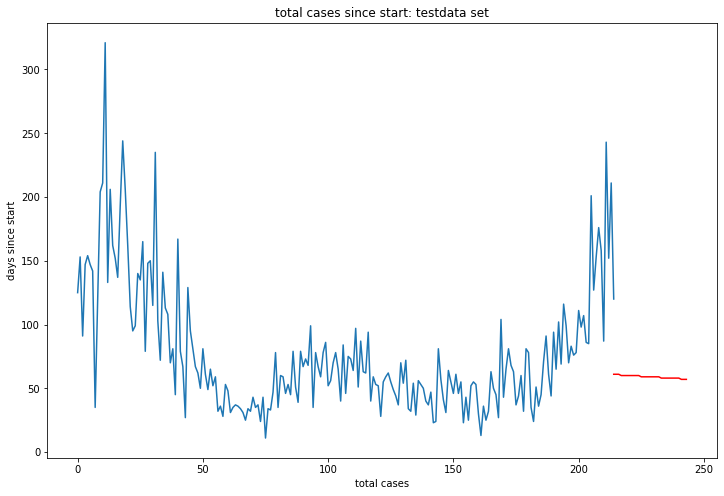

In [540]:
fig,ax = plt.subplots(figsize=(12,8))
plt.plot(reg_df['days_since_start'],reg_df['total_cases'])
plt.plot(forecast_date_range,forecast_values,color='red')
plt.xlabel('total cases')
plt.ylabel('days since start')
plt.title('total cases since start: testdata set');

# Model 2: Modified Linear Regression using higher order polynomials

In [568]:
from sklearn.preprocessing import PolynomialFeatures
#degree 2 makes it curve a bit
poly_reg = PolynomialFeatures(degree=2)
X_train_poly_transformed = poly_reg.fit_transform(X_train)
X_test_poly_transformed = poly_reg.fit_transform(X_test)

In [569]:
poly_regressor = LinearRegression()
poly_regressor.fit(X_train_poly_transformed, y_train);

In [556]:
poly_predict = poly_regressor.predict(X_train_poly_transformed)

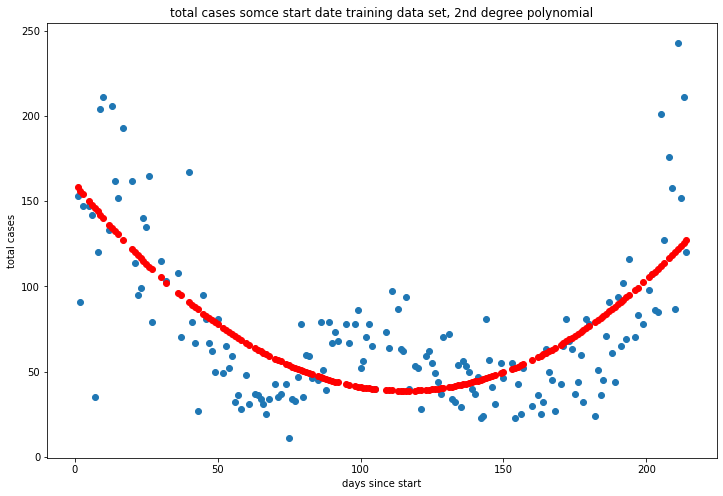

In [557]:
fig,ax = plt.subplots(figsize=(12,8))
plt.scatter(X_train,y_train)
plt.scatter(X_train,poly_predict,color='red')
plt.xlabel('days since start')
plt.ylabel('total cases')
plt.title('total cases somce start date training data set, 2nd degree polynomial');

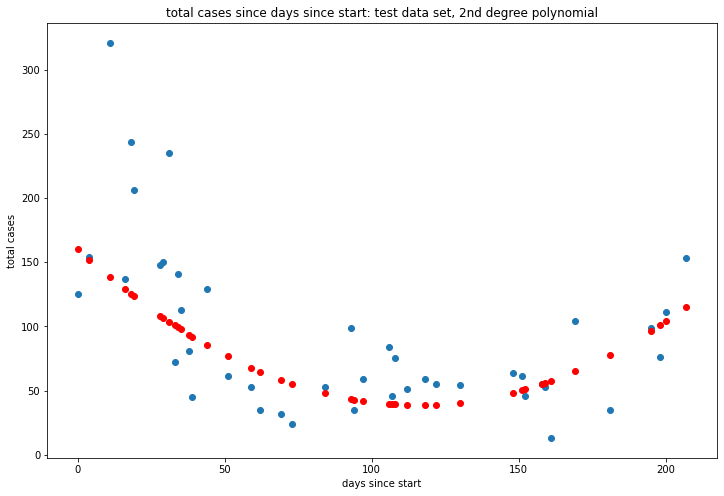

In [558]:
fig,ax = plt.subplots(figsize=(12,8))
plt.scatter(X_test,y_test)
plt.scatter(X_test,poly_regressor.predict(poly_reg.fit_transform(X_test)),color='red')
plt.xlabel('days since start')
plt.ylabel('total cases')
plt.title('total cases since days since start: test data set, 2nd degree polynomial');

In [572]:
#Get RMSE for 2nd model

poly_reg_mse = mean_squared_error(y_test,poly_regressor.predict(X_test_poly_transformed),squared=False)

print(f'RMSE for this model is {round(poly_reg_mse,2)}')

#This rmse is smaller and better than the first one

RMSE for this model is 48.71


In [576]:
#forecast the next 30 days
forecast_values = []

for n in forecast_date_range:
  n_transformed = poly_reg.fit_transform(n.reshape(1,-1))
  prediction = round(poly_regressor.predict(n_transformed)[0][0])
  print(f'on the {n}th day, beginning November 20, 2020 the model predicts: {prediction} cases')
  forecast_values.append(prediction)

on the 214th day, beginning November 20, 2020 the model predicts: 127.0 cases
on the 215th day, beginning November 20, 2020 the model predicts: 129.0 cases
on the 216th day, beginning November 20, 2020 the model predicts: 131.0 cases
on the 217th day, beginning November 20, 2020 the model predicts: 133.0 cases
on the 218th day, beginning November 20, 2020 the model predicts: 135.0 cases
on the 219th day, beginning November 20, 2020 the model predicts: 136.0 cases
on the 220th day, beginning November 20, 2020 the model predicts: 138.0 cases
on the 221th day, beginning November 20, 2020 the model predicts: 140.0 cases
on the 222th day, beginning November 20, 2020 the model predicts: 142.0 cases
on the 223th day, beginning November 20, 2020 the model predicts: 144.0 cases
on the 224th day, beginning November 20, 2020 the model predicts: 146.0 cases
on the 225th day, beginning November 20, 2020 the model predicts: 148.0 cases
on the 226th day, beginning November 20, 2020 the model predicts

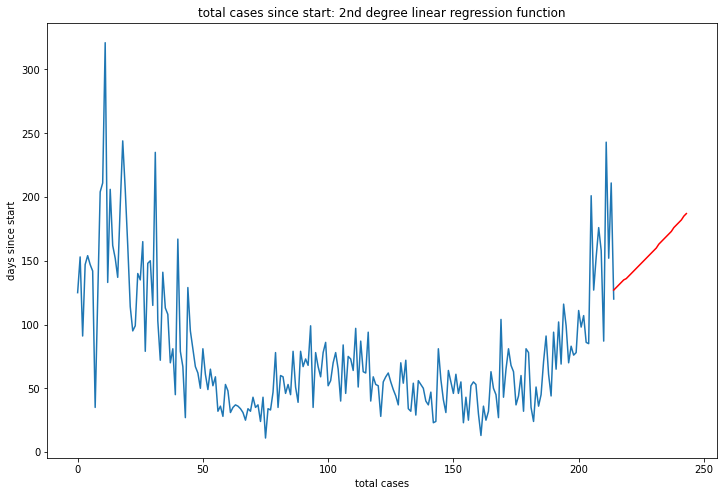

In [579]:
fig,ax = plt.subplots(figsize=(12,8))
plt.plot(reg_df['days_since_start'],reg_df['total_cases'])
plt.plot(forecast_date_range,forecast_values,color='red')
plt.xlabel('total cases')
plt.ylabel('days since start')
plt.title('total cases since start: 2nd degree linear regression function');

# Model 3: Incorporating multiple variables in regression

In [814]:
#new x and y split

X = master_df.drop(['Ward','total_deaths','date'],axis=1)
y = master_df['total_cases']

X = X.resample(rule='D').sum()
y = y.resample(rule='D').sum()


#take care of Null cells because it'll give errors
X.fillna(0,inplace=True)
y.fillna(0,inplace=True)



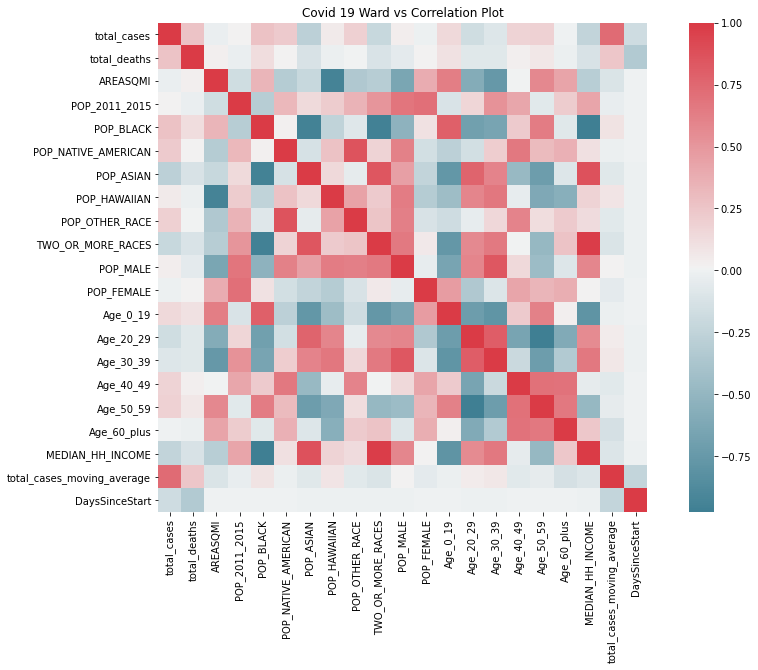

In [794]:
#check for linearity between variables
import seaborn as sns
fig,ax = plt.subplots(figsize=(15,9))
corr = master_df.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, 
            cmap=sns.diverging_palette(220,10,as_cmap=True),
            square=True, 
            ax=ax).set_title('Covid 19 Ward vs Correlation Plot');


In [815]:
#new train test split based on newer columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

#sanity check
print(f"X_train size: {X_train.shape}, X_testsize: {X_test.shape}, train size + test size = {X_train.shape[0] + X_test.shape[0]} , original dataframe size: {len(master_df['total_deaths'])}")



X_train size: (172, 20), X_testsize: (43, 20), train size + test size = 215 , original dataframe size: 1720


In [816]:
multiple_reg = LinearRegression(fit_intercept=True)

In [817]:
multiple_reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [818]:
multi_dict = {}

for coef, feat in zip(multiple_reg.coef_, X_train.columns):
  multi_dict[feat] = coef

#seems like none of the features are significant, other # of cases
pd.DataFrame.from_dict(multi_dict,orient='index')


,0
total_cases,1.00
AREASQMI,-0.00
POP_2011_2015,0.00
POP_BLACK,0.00
POP_NATIVE_AMERICAN,0.00
POP_ASIAN,0.00
POP_HAWAIIAN,0.00
POP_OTHER_RACE,0.00
TWO_OR_MORE_RACES,0.00
POP_MALE,0.00


In [821]:
# prediction 

multiple_reg_predict = multiple_reg.predict(X_test)
multi_df = pd.DataFrame({'Actual': y_test, 'Predicted': multiple_reg_predict})
multi_df

,Actual,Predicted
date_index,,
2020-08-05,75,75.00
2020-11-12,153,153.00
2020-08-03,84,84.00
2020-08-04,46,46.00
2020-06-09,61,61.00
2020-05-22,72,72.00
2020-06-17,53,53.00
2020-09-18,46,46.00
2020-04-23,154,154.00


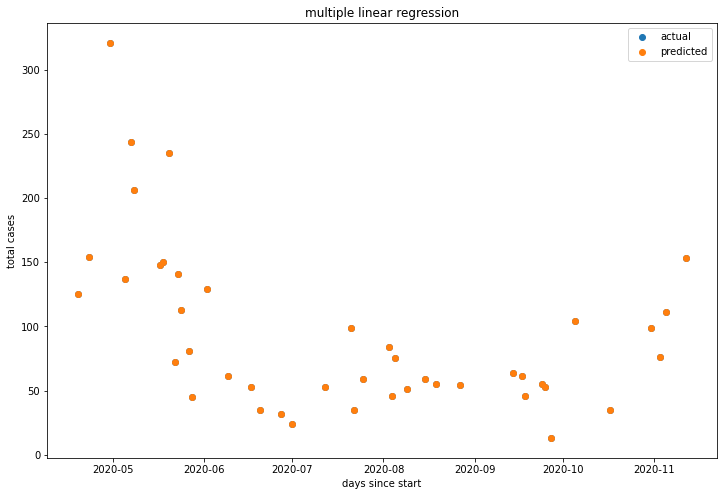

In [810]:
fig,ax = plt.subplots(figsize=(12,8))

plt.scatter(multi_df.index, multi_df['Actual'],label='actual')
plt.scatter(multi_df.index, multi_df['Predicted'],label='predicted')

plt.legend()
plt.xlabel('days since start')
plt.ylabel('total cases')
plt.title('multiple linear regression');

#--- Modeling using time (Time Series) ---


# Model 4: Time Series - exploration using 3 day moving averages and 30 day moving average


In [692]:
#starting point scatter plot
time_df = master_df[['total_cases','total_deaths']]

cases_month_df = time_df.resample(rule='D').sum()
cases_month_df['days since start'] = [x for x in range(len(cases_month_df))]

time_train = cases_month_df[:-30]
time_test = cases_month_df[-30:]



Text(0.5, 0, 'days since start')

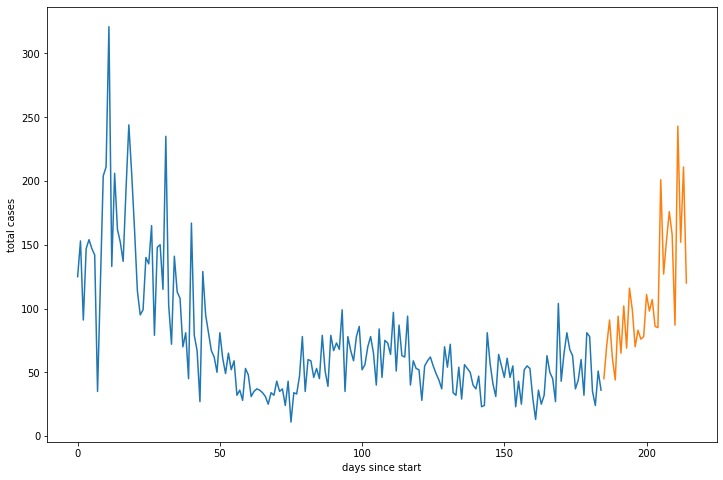

In [694]:
fig,ax = plt.subplots(figsize=(12,8))

plt.plot(time_train['days since start'], time_train['total_cases'],label='training')
plt.plot(time_test['days since start'], time_test['total_cases'].values,label='test')
plt.ylabel('total cases')
plt.xlabel('days since start')

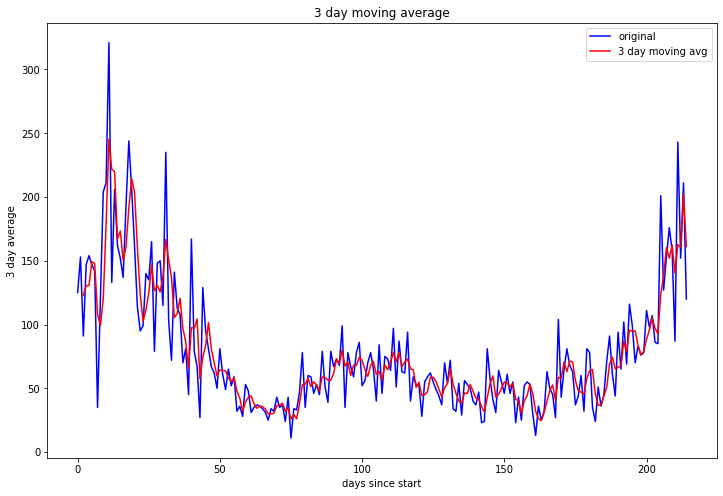

In [749]:
#set moving average window
moving_average_window = 3
cases_month_df['3_day_moving_average'] = cases_month_df['total_cases'].rolling(moving_average_window).mean()

fig,ax = plt.subplots(figsize=(12,8))
plt.plot(cases_month_df['days since start'],cases_month_df['total_cases'], color='blue', label='original')
plt.plot(cases_month_df['days since start'],cases_month_df['3_day_moving_average'],color='red',label='3 day moving avg')
plt.ylabel('3 day average')
plt.xlabel('days since start')
plt.title('3 day moving average')
plt.legend()



In [675]:
ma_mse = mean_squared_error(cases_month_df['3_day_moving_average'].dropna(),cases_month_df['total_cases'][2:].dropna(), squared=False)
print(f'RMSE: {ma_mse}')

RMSE: 23.136662774031365


In [739]:
#predicting the next 30 days using the last 30 days average

thirty_day_avg = np.mean(cases_month_df['total_cases'][-30:].values)
print(f'Thirty Day Avg {thirty_day_avg}')

vals_last_30 = cases_month_df['total_cases'][-30:].values.tolist()
ave_predictions = []

for i in range(30):
  run_sum = 0 
  if i == 0:
    ave_predictions.append(thirty_day_avg)
  else:
    run_sum = sum(vals_last_30[i:]) + sum(predictions[:(i-1)])
    ave_predictions.append(run_sum/30)



Thirty Day Avg 109.3


30

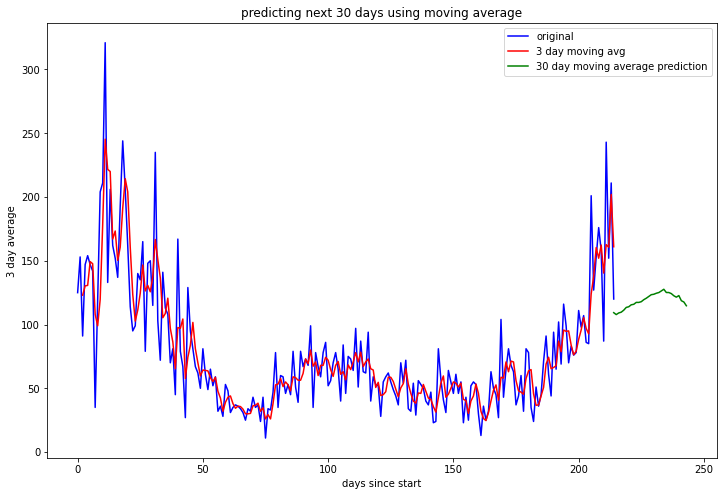

In [752]:
fig,ax = plt.subplots(figsize=(12,8))
plt.plot(cases_month_df['days since start'],cases_month_df['total_cases'], color='blue', label='original')
plt.plot(cases_month_df['days since start'], cases_month_df['3_day_moving_average'],color='red',label='3 day moving avg')
plt.plot([x for x in range(214,244,1)], ave_predictions, label='30 day moving average prediction',color='green')
plt.ylabel('3 day average')
plt.xlabel('days since start')
plt.title('predicting next 30 days using moving average')
plt.legend()


In [764]:
print(f'Next 30 days after November 19 - Minimum: {min(ave_predictions)} cases, Maximum {max(ave_predictions)} cases')
for n in ave_predictions:
  print(f'prediction on day {round(214+ave_predictions.index(n))}: {n}')

Next 30 days after November 19 - Minimum: 107.8 cases, Maximum 127.65013890668953 cases
prediction on day 214: 109.3
prediction on day 215: 107.8
prediction on day 216: 109.07666666666667
prediction on day 217: 109.68666666666667
prediction on day 218: 111.24666666666667
prediction on day 219: 113.41588888888889
prediction on day 220: 113.93877777777779
prediction on day 221: 115.48033333333333
prediction on day 222: 115.86086296296295
prediction on day 223: 117.35882222222222
prediction on day 224: 117.3415
prediction on day 225: 117.9035287654321
prediction on day 226: 119.4821561728395
prediction on day 227: 120.62687283950618
prediction on day 228: 122.02365713168724
prediction on day 229: 123.40639567078189
prediction on day 230: 123.72729143209877
prediction on day 231: 124.52808000315501
prediction on day 232: 125.07495985884773
prediction on day 233: 126.3325362399177
prediction on day 234: 127.65013890668953
prediction on day 235: 125.11930423531778
prediction on day 236: 125.

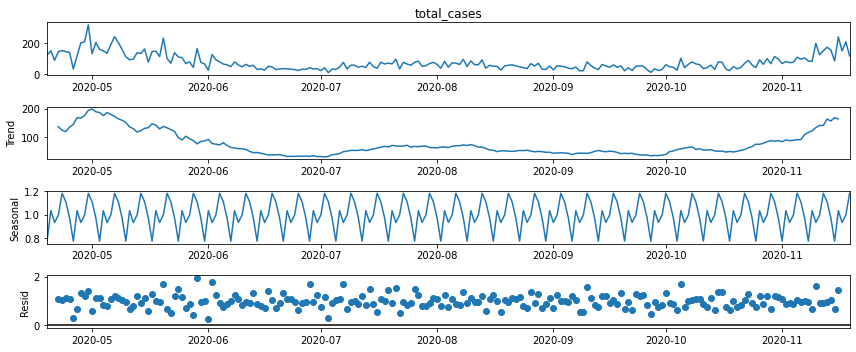

In [679]:
#understanding trend, seasonality and residuals

from pylab import rcParams
rcParams['figure.figsize'] = 12,5
#seasonal decomposition

from statsmodels.tsa.seasonal import seasonal_decompose
season_decomp = seasonal_decompose(cases_month_df['total_cases'],model='multiplicative')

season_decomp.plot();

In [665]:
#trying exponential smoothing

In [ ]:
!pip install pmdarima;

# Model 5: ARIMA/SARIMAX


In [831]:
#checking for stationarity, if p value below 0.05, it is stationary
time_train = time_train['total_cases']
from statsmodels.tsa.stattools import adfuller

adfuller_values = adfuller(time_train)
print('p-value: {}'.format(adfuller_values[1]))


p-value: 0.4079593138537971


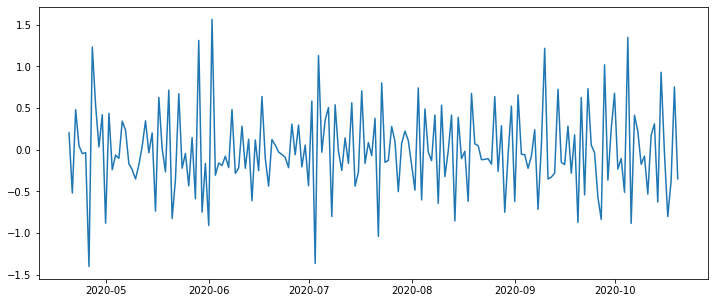

In [854]:
#p value is > 0.06 so we need to make the time series stationary using exponential smoothing
time_train_log = np.log(time_train)

time_train_shifted = time_train_log - time_train_log.shift()
time_train_shifted.dropna(inplace=True)
plt.plot(time_train_shifted);


In [855]:
# credit to stackoverflow solution https://stackoverflow.com/questions/56802974/auto-arima-r-and-python-suggest-different-arima-models-for-same-data-why as pmd autoarima varies every runtime
# import package
import itertools

# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in 
list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))


warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(time_train_shifted,
                                     order=param,
                                     seasonal_order=param_seasonal,
                                     enforce_stationarity=False,
                                     enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 0, 2, 12)
SARIMAX: (0, 0, 2) x (0, 1, 0, 12)
SARIMAX: (0, 0, 2) x (0, 1, 1, 12)


In [862]:
#using sarimax option 3
sarimax_model = SARIMAX(time_train, order = (0,0,2), seasonal_order=(0,1,0,12))
sarimax_results = sarimax_model.fit(disp=False)

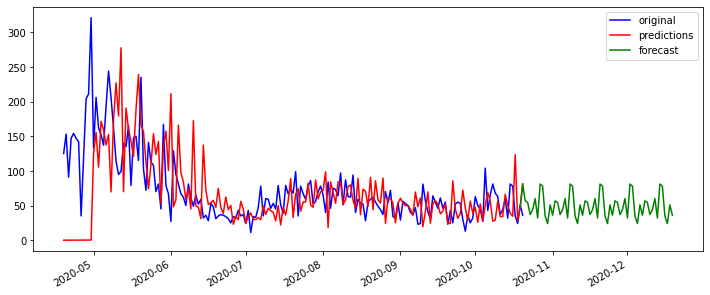

In [870]:

plt.plot(time_train,label='original',color='blue')
plt.plot(sarimax_results.fittedvalues,label='predictions',color='red')
sarimax_results.predict('2020-10-19','2020-12-19').plot(color='green',label='forecast')
plt.legend()

In [871]:
prediction_sarimax = sarimax_results.predict('2020-10-19','2020-12-19')

In [874]:
prediction_sarimax.to_frame().rename({0:'Predictions'}, axis=1)

,Predictions
2020-10-19,47.25
2020-10-20,81.25
2020-10-21,56.79
2020-10-22,54.44
2020-10-23,37.00
...,...
2020-12-15,78.00
2020-12-16,35.00
2020-12-17,24.00
2020-12-18,51.00


In [880]:
sarimax_rmse = mean_squared_error(sarimax_results.predict('2020-04-20','2020-10-1'),time_train['2020-04-20':'2020-10-1'],squared=False)
print(f'RMSE is {sarimax_rmse}')

RMSE is 61.104262901175005
